In [1]:
from model_training.data import get_ratings_data, stratify_ratings_data

rating_bucket_name = "canihaveatvshowplz-staging-ratingsexport"
rating_file_name = "ratings-1.0.0.csv"

ratings_df = get_ratings_data(rating_bucket_name, rating_file_name)
train_set, test_set = stratify_ratings_data(ratings_df)

train_set.head()

,UserId,ShowId,IsLiked
172349,615dc2cf-d8b4-4eb7-9b36-df86abf13736,2639f4cc-3d45-42fe-b002-91ee16d4eccf,0
157046,79f64afb-581f-4497-91df-9f6f160b8501,f1175e6b-e29b-4c95-ab92-8b5701e6119f,0
102452,8e9c1c7e-bc79-42f1-aac1-362e72561bfb,0c9534d2-9f29-4c09-a396-4bf6cb69feff,0
2683,6b229cab-2d4f-4954-ad5c-0482543d62c5,67c2a129-5b9a-4f3d-8944-d0bfb8f58838,0
10492,82d8510f-0dcc-4fb2-8219-474a792461fa,c67a1f57-3e1d-46bc-868f-6fa3fb976649,0


In [2]:
from model_training.pipelines import get_knn_graph_pipeline
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

pipeline = get_knn_graph_pipeline(label_encoder=label_encoder)

df = pipeline.fit_transform(train_set)
transposed_df = df.T

transposed_df.head()

UserIdEncoded,0,1,2,3,4,5,6,7,8,9,...,405,406,407,408,409,410,411,412,413,414
ShowIdEncoded,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sklearn.neighbors import NearestNeighbors


model = NearestNeighbors(n_neighbors=5, metric="jaccard", n_jobs=-1)
model.fit(transposed_df)


NearestNeighbors(metric='jaccard', n_jobs=-1)

In [ ]:
from model_training.graph import generate_graph

graph = generate_graph(model, df)

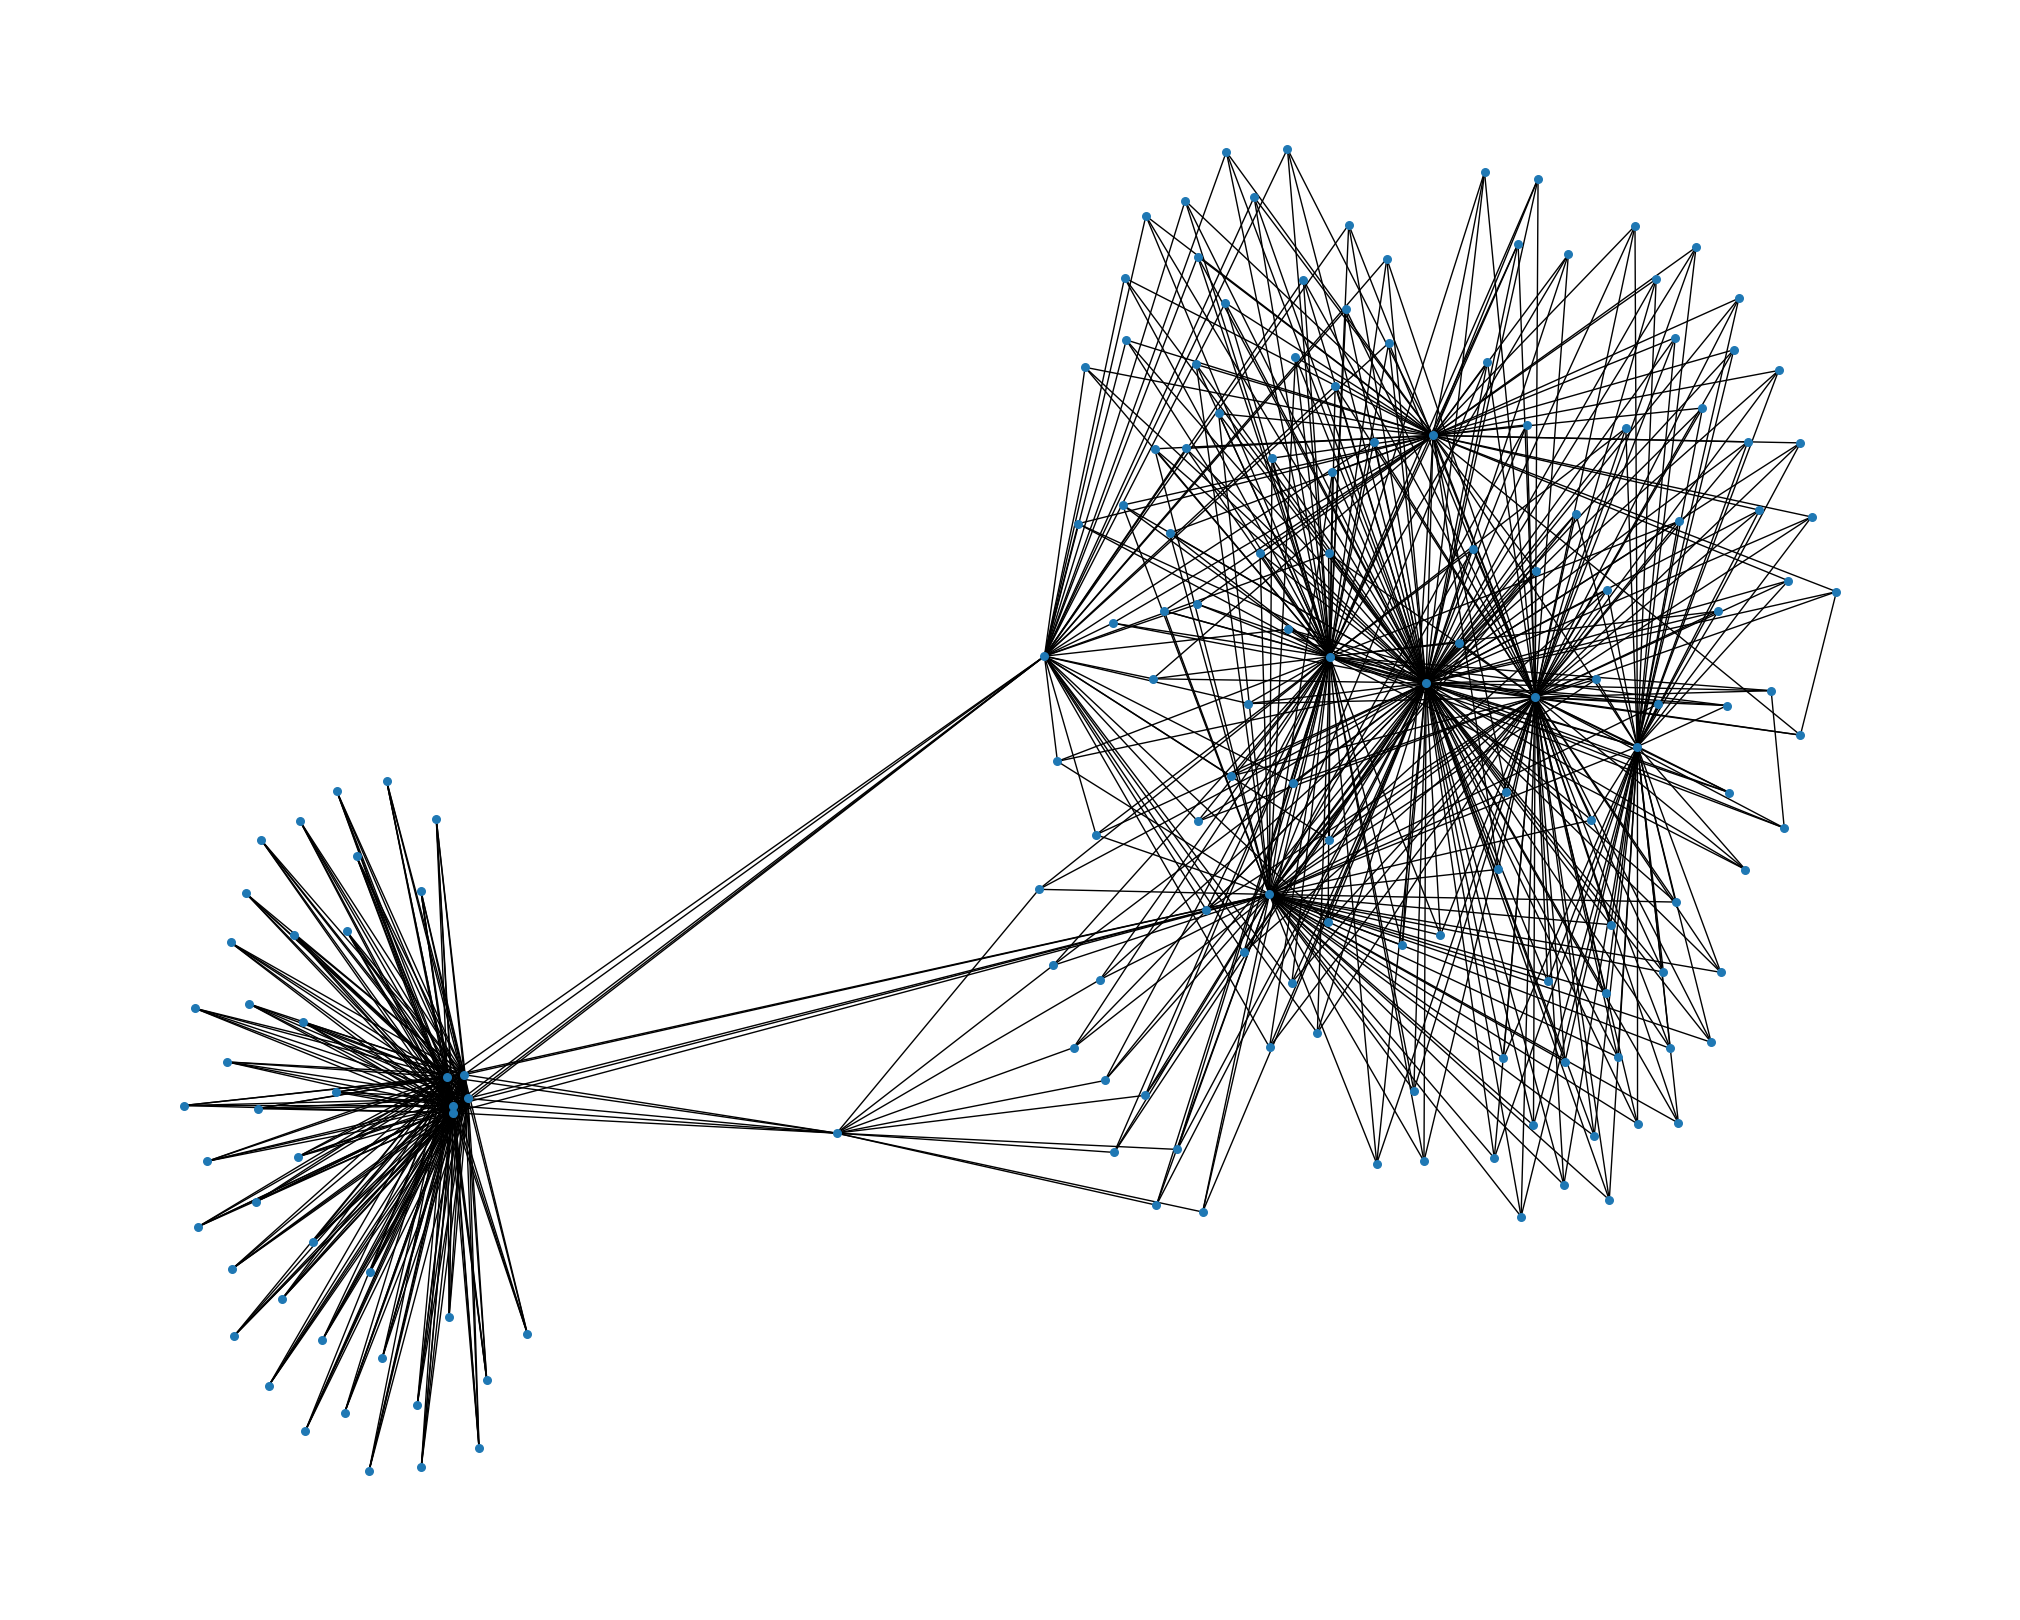

In [5]:
import networkx as nx
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 16))
pos = nx.spring_layout(graph)  # Layout algorithm to position nodes
nx.draw(graph, pos, with_labels=False, node_size=30)
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder

def generate_show_recommendations(graph, show_ids, top_n=5):
    similar_shows = {}

    for show_id in show_ids:
        if show_id in graph:
            neighbors = list(graph.neighbors(show_id))

            # Count common neighbors for each neighbor of the input show
            for neighbor in neighbors:
                if neighbor != show_id:
                    if neighbor in similar_shows:
                        similar_shows[neighbor] += 1
                    else:
                        similar_shows[neighbor] = 1

    sorted_shows = sorted(similar_shows.items(), key=lambda x: x[1], reverse=True)

    recommended_shows = [show[0] for show in sorted_shows[:top_n] if show[0] not in show_ids]

    return recommended_shows

show_ids = [
    "d80909fb-f7cb-46c7-bb31-463f56184faa", # Star Trek: TNG
]

label_encoder = LabelEncoder()
label_encoder.fit_transform(train_set['ShowId'])
encoded_show_ids = label_encoder.transform(show_ids)

recommended_shows = generate_show_recommendations(graph, encoded_show_ids)

decoded_recommended_shows = label_encoder.inverse_transform(recommended_shows)

print(decoded_recommended_shows)

['79ac6112-cec2-4d3b-b584-68f832613c9f'
 'a2424baf-db2c-4ffb-82ca-4751afe16f5c'
 'a194c151-7f09-492b-9ab7-efab4390989b'
 'a0f13466-21ec-4b7c-af81-6cbb8211600d']
